# Preprocessing and filtering raw data
### 1. Packages Initliazation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

### 2. Unpacking pickle files and removing unwanted batteries 

In [2]:
batch1 = pickle.load(open(r'.\Data\batch1.pkl', 'rb'))
batch2 = pickle.load(open(r'.\Data\batch2.pkl','rb'))
batch3 = pickle.load(open(r'.\Data\batch3.pkl','rb'))

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1

batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];


In [3]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [4]:
#remove batteries that do not reach 80% capacity

del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [5]:
numBat1 = len(batch1.keys())
numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
numBat

print(f'Batch1 :',numBat1)
print(f'Batch2 :',numBat2)
print(f'Batch3 :',numBat3)
print(f'Total batch :', numBat)

bat_dict = {**batch1, **batch2, **batch3}
bat_dict.keys()

Batch1 : 42
Batch2 : 43
Batch3 : 40
Total batch : 125


dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29'

### 3. Plotting battery parameters

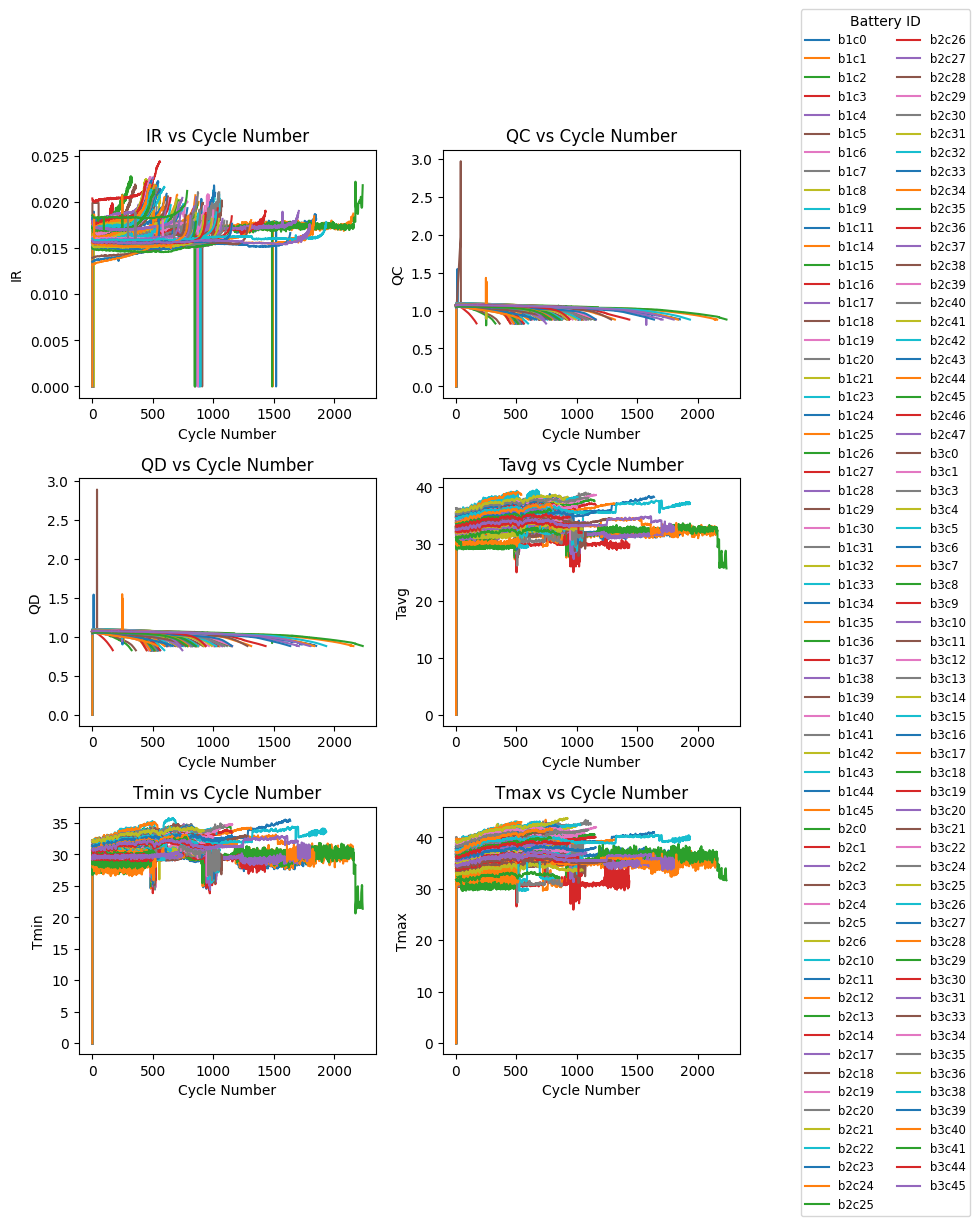

In [6]:

features_to_plot = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax']

# Create a 3x2 grid for subplots (for 6 features)
fig, axes = plt.subplots(3, 2, figsize=(8, 10))  
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# For storing the plot lines and labels for a shared legend
lines = []
labels = []

# Plot each feature on a separate subplot
for idx, feature in enumerate(features_to_plot):
    for i in bat_dict.keys():
        line, = axes[idx].plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary'][feature], label=i)  
        if idx == 0:  # Collect labels from the first plot only for a shared legend
            lines.append(line)
            labels.append(i)
    axes[idx].set_title(f'{feature} vs Cycle Number')  # Set title for each subplot
    axes[idx].set_xlabel('Cycle Number')
    axes[idx].set_ylabel(feature)

# Remove the last empty subplot if any
if len(features_to_plot) < len(axes):
    fig.delaxes(axes[-1])

# Create a single legend for the entire figure
fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title="Battery ID", ncol=2)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout so the legend fits nicely outside
plt.show()


### 4. Train and Test Split (As per the paper)
If you are interested in using the same train/test split as the paper, use the indices specified below

In [7]:
test_ind = np.arange(0,(numBat1+numBat2),2)                 # Batteries 0 to 83 (all even indices) -44 batteries
train_ind = np.arange(1,(numBat1+numBat2-1),2)              # Batteries 0 to 83 (all odd indices) - 42 batteries
secondary_test_ind = np.arange(numBat-numBat3,numBat);      # Batteries 84 to 126 - 40 batteries

In [8]:
train_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in train_ind if i < len(bat_dict)}
valida_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in test_ind if i < len(bat_dict)}
test_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in secondary_test_ind if i < len(bat_dict)}

batch1.keys()  

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

### 5. Data structure (for each battery as key)



In [30]:
"""
batch entry structure (for refernce):

batch1['b1c0']
│
├── cycle_life: NumPy array
│       [1852.]
│
├── charge_policy: String
│       "3.6C(80%)-3.6C"
│
├── summary: Dictionary
│   ├── IR: NumPy array (Internal Resistance over cycles)
│   ├── QC: NumPy array (Charge Capacity over cycles)
│   ├── QD: NumPy array (Discharge Capacity over cycles)
│   ├── Tavg: NumPy array (Average Temperature over cycles)
│   ├── Tmin: NumPy array (Minimum Temperature over cycles)
│   ├── Tmax: NumPy array (Maximum Temperature over cycles)
│   ├── chargetime: NumPy array (Charging time over cycles)
│   └── cycle: NumPy array (Cycle numbers)
│
└── cycles: Dictionary (Detailed per-cycle data)
    ├── '0': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    ├── '1': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    └── ... : Additional cycles ('2', '3', ..., '1851')
    """

'\nbatch entry structure (for refernce):\n\nbatch1[\'b1c0\']\n│\n├── cycle_life: NumPy array\n│       [1852.]\n│\n├── charge_policy: String\n│       "3.6C(80%)-3.6C"\n│\n├── summary: Dictionary\n│   ├── IR: NumPy array (Internal Resistance over cycles)\n│   ├── QC: NumPy array (Charge Capacity over cycles)\n│   ├── QD: NumPy array (Discharge Capacity over cycles)\n│   ├── Tavg: NumPy array (Average Temperature over cycles)\n│   ├── Tmin: NumPy array (Minimum Temperature over cycles)\n│   ├── Tmax: NumPy array (Maximum Temperature over cycles)\n│   ├── chargetime: NumPy array (Charging time over cycles)\n│   └── cycle: NumPy array (Cycle numbers)\n│\n└── cycles: Dictionary (Detailed per-cycle data)\n    ├── \'0\': Dictionary\n    │   ├── I: NumPy array (Current data)\n    │   ├── Qc: NumPy array (Charge capacity data)\n    │   ├── Qd: NumPy array (Discharge capacity data)\n    │   ├── Qdlin: NumPy array (Linearized discharge capacity)\n    │   ├── T: NumPy array (Temperature data)\n    

# Feature Engineering

### 1. Filtering (z-score based) and strandadizing train, test and validation data 

In [9]:
def add_cleaned_summary(data_dict):
    for key in data_dict:
        cleaned_summary = pd.DataFrame(data_dict[key]['summary']).copy()
        z_scores = np.abs(zscore(cleaned_summary.iloc[:, 0:-1]))
        threshold = 3
        filtered_entries = (z_scores < threshold).all(axis=1)
        cleaned_summary = cleaned_summary[filtered_entries]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(cleaned_summary.iloc[:, 0:-1])
        cleaned_summary.iloc[:, 0:-1] = scaled_features
        data_dict[key]['cleaned_summary'] = cleaned_summary

add_cleaned_summary(train_data)
add_cleaned_summary(test_data)
add_cleaned_summary(valida_data)

In [10]:
features = train_data['b1c1']['cleaned_summary'].iloc[:, 0:-1]

In [33]:
# # For Battery b1c0 (To be delted after generalization)

# b1c0_summary_df = pd.DataFrame(batch1['b1c0']['summary'])
# features = pd.DataFrame(batch1['b1c0']['summary']).iloc[:, 0:-1]
# target = pd.DataFrame(batch1['b1c0']['summary']).iloc[:,-1]
# features.head()
# z_scores = np.abs(zscore(features))
# threshold = 3
# filtered_entries = (z_scores < threshold).all(axis=1)
# features = features[filtered_entries]


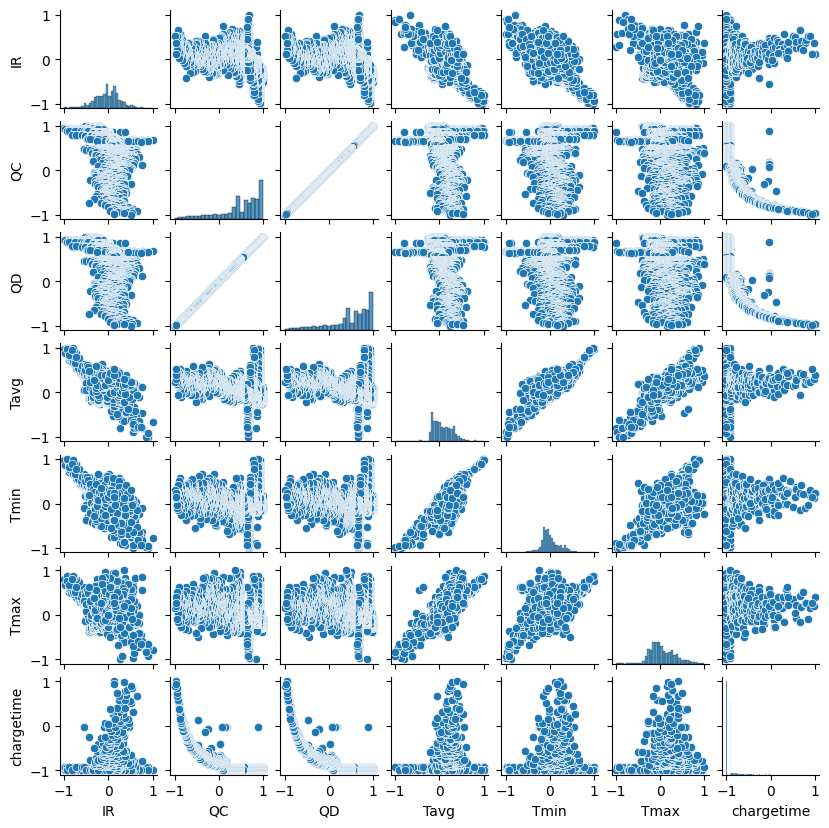

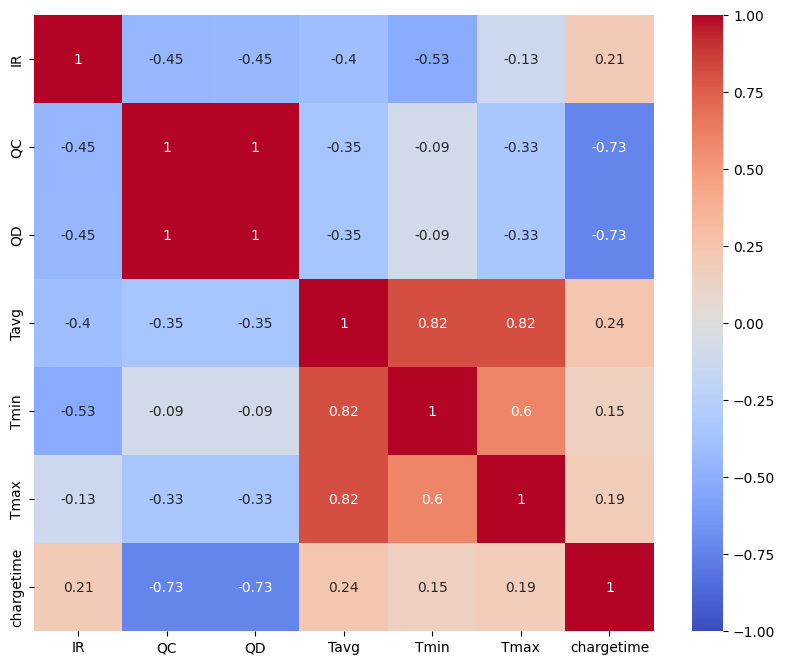

In [ ]:
# Min-Max Scaler adjusted to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for plotting
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Pairplot with scaled features
sns.pairplot(scaled_features_df, height=1.2)
plt.show()

# Compute correlation matrix for scaled features
correlation_matrix = scaled_features_df.corr()

# Heatmap with a new colormap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='viridis',   # Try 'plasma', 'RdBu', or 'coolwarm_r' for different effects
    vmin=-1, 
    vmax=1
)
plt.title("Pearson Correlation Heatmap")
plt.show()

In [35]:

reduced_features = features.copy()
reduced_features['Capacity_Ratio'] = reduced_features['QC'] / reduced_features['QD']
reduced_features['T_del'] = reduced_features['Tmax'] - reduced_features['Tmin']
reduced_features['ChargeTime_per_Qc'] = reduced_features['chargetime'] / reduced_features['QC']
reduced_features = reduced_features.drop(['QC', 'QD', 'Tmin', 'Tmax'], axis=1)

# This take too much time, uncomment if you want to run it

# sample_data = reduced_features
# # sample_data = reduced_features.sample(1000)  # Adjust as needed
# sns.pairplot(reduced_features[['Capacity_Ratio', 'T_del', 'ChargeTime_per_Qc', 'IR']], height=1.5)
# plt.show()

# correlation_matrix = reduced_features.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()


In [36]:
# Function to create and assign reduced features
def create_reduced_features(data_dict):
    for key in data_dict.keys():
        # Extract the features for each battery
        features = data_dict[key]['cleaned_summary']
        
        # Create reduced features
        reduced_features = features.copy()
        reduced_features['Capacity_Ratio'] = reduced_features['QC'] / reduced_features['QD']
        reduced_features['T_del'] = reduced_features['Tmax'] - reduced_features['Tmin']
        reduced_features['ChargeTime_per_Qc'] = reduced_features['chargetime'] / reduced_features['QC']
        reduced_features = reduced_features.drop(['QC', 'QD', 'Tmin', 'Tmax'], axis=1)
        
        # Assign the reduced features back to the data dictionary
        data_dict[key]['reduced_features'] = reduced_features

# Apply the function to train_data, test_data, and valid_data
create_reduced_features(train_data)
create_reduced_features(test_data)
create_reduced_features(valida_data)

# Example: Display the reduced features for battery 'b1c1' in train_data
train_data['b1c1']['reduced_features'].head()


,IR,Tavg,chargetime,cycle,Capacity_Ratio,T_del,ChargeTime_per_Qc
1,-0.726509,-0.267220,-0.162144,2.0,1.000012,-1.078982,-0.169769
2,-0.831571,-0.191578,-0.498587,3.0,1.001725,-0.949269,-0.506517
3,-1.126172,-0.155763,-0.163046,4.0,1.001227,-0.932578,-0.163325
4,-1.173732,-0.120868,-0.161998,5.0,0.996922,-0.858659,-0.160097
5,-1.376713,-0.129135,-0.161375,6.0,1.001022,-0.998836,-0.157543


# Algorthm implementation
### 1. Random Forest implementation - Indivisual Batteries

In [53]:
# Prepare a dictionary to store the MSE and R² results for each battery and fold
validation_results = {}

# Number of folds for cross-validation
n_splits = 3

# Loop through each battery in bat_dict
for battery_id, battery_data in bat_dict.items():
    battery_features = battery_data['cleaned_summary'].iloc[:, :-1]  # Select all columns except the last one as features
    battery_target = battery_data['cleaned_summary'].iloc[:, -1]     # Select the last column as the target variable
    
    # Prepare K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_idx = 1  # Track the fold number
    
    # Loop through each fold
    for train_index, val_index in kf.split(battery_features):
        # Split data into train and validation sets for the current fold
        X_train, X_val = battery_features.iloc[train_index], battery_features.iloc[val_index]
        y_train, y_val = battery_target.iloc[train_index], battery_target.iloc[val_index]
        
        # Train Random Forest model on the current fold
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_pred = model.predict(X_val)
        
        # Compute metrics
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        # Store results for this battery and fold
        validation_results[f"{battery_id}_fold_{fold_idx}"] = {'Battery': battery_id, 'Fold': fold_idx, 'MSE': mse, 'R²': r2}
        
        # Increment fold index
        fold_idx += 1

# Convert results to a DataFrame
scores_df = pd.DataFrame(validation_results).T

# Reset index to get a clean DataFrame
scores_df.reset_index(drop=True, inplace=True)

# Display the validation results
print(scores_df)

    Battery Fold          MSE        R²
0      b1c0    1   973.598815   0.99652
1      b1c0    2  1170.143197  0.995851
2      b1c0    3  1378.528931  0.995011
3      b1c1    1   233.616954  0.999399
4      b1c1    2   406.440474   0.99895
..      ...  ...          ...       ...
370   b3c44    2   219.983478  0.996983
371   b3c44    3    60.289608  0.999112
372   b3c45    1    47.843356   0.99981
373   b3c45    2    43.462626  0.999826
374   b3c45    3    27.528422  0.999889

[375 rows x 4 columns]


In [54]:
scores_df['MSE'].mean(), scores_df['R²'].mean()

(66.80926831941451, 0.9983177303814503)

### 2. Random Forest implementation - Generalized battery model

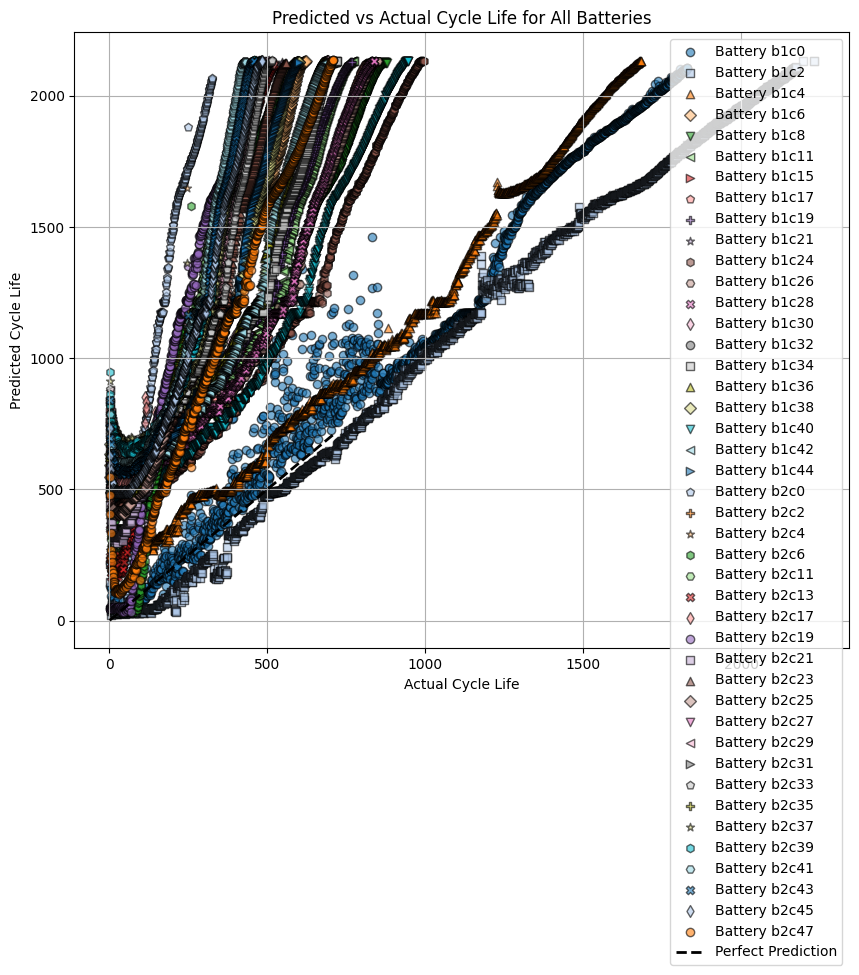

                MSE          R²
b1c0   3.759911e+04    0.865900
b1c2   2.953680e+03    0.992525
b1c4   6.822945e+04    0.711511
b1c6   7.449034e+05  -22.336328
b1c8   5.120908e+05   -6.980958
b1c11  5.902782e+05  -10.902501
b1c15  6.408226e+05  -14.122713
b1c17  5.397494e+05   -8.334350
b1c19  6.031563e+05  -11.312874
b1c21  8.689417e+05  -33.962248
b1c24  4.207540e+05   -4.109960
b1c26  5.268791e+05   -7.741500
b1c28  5.352289e+05   -8.146046
b1c30  6.617894e+05  -15.622719
b1c32  6.452636e+05  -14.360403
b1c34  6.367149e+05  -13.727424
b1c36  6.688794e+05  -16.195551
b1c38  7.504098e+05  -24.117962
b1c40  4.584565e+05   -5.161436
b1c42  6.675918e+05  -16.113550
b1c44  7.500591e+05  -24.100424
b2c0   1.162652e+06 -131.210202
b2c2   9.047811e+05  -50.649393
b2c4   9.254619e+05  -49.807070
b2c6   9.373181e+05  -37.407650
b2c11  9.196623e+05  -48.432501
b2c13  8.649548e+05  -37.904025
b2c17  8.433174e+05  -37.190092
b2c19  9.978328e+05  -55.990926
b2c21  8.989592e+05  -44.860587
b2c23  8

In [ ]:
# Select the first battery from train_data
train_battery = list(train_data.keys())[0]
train_features = train_data[train_battery]['cleaned_summary'].iloc[:, :-1]
train_target = train_data[train_battery]['cleaned_summary'].iloc[:, -1]

# Train Random Forest model on the first battery
model = RandomForestRegressor(random_state=42)
model.fit(train_features, train_target)

# Prepare to store validation results
validation_results = {}

# Create a combined plot
plt.figure(figsize=(10, 8))

# Different markers and colors for each battery
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'P', '*', 'h', 'H', 'X', 'd']
colors = plt.cm.tab20.colors  # Use a colormap with sufficient distinct colors

# Validate on each battery in valida_data
for idx, battery in enumerate(valida_data.keys()):
    val_features = valida_data[battery]['cleaned_summary'].iloc[:, :-1]
    val_target = valida_data[battery]['cleaned_summary'].iloc[:, -1]
    val_pred = model.predict(val_features)
    
    # Compute metrics
    mse = mean_squared_error(val_target, val_pred)
    r2 = r2_score(val_target, val_pred)
    validation_results[battery] = {'MSE': mse, 'R²': r2}
    
    # Scatter plot for this battery
    plt.scatter(val_target, val_pred, alpha=0.6, edgecolors='k',
                marker=markers[idx % len(markers)], color=colors[idx % len(colors)],
                label=f'Battery {battery}')
    
# Add perfect prediction line
plt.plot([min(val_target), max(val_target)], [min(val_target), max(val_target)], 'k--', lw=2, label='Perfect Prediction')

# Add plot labels and legend
plt.xlabel("Actual Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life for All Batteries")
plt.legend()
plt.grid(True)
plt.show()

# Display validation results as a DataFrame
validation_df = pd.DataFrame(validation_results).T
print(validation_df)


In [51]:
validation_df['MSE'].mean(), validation_df['R²'].mean()

(721268.7257829547, -30.577839881110627)

# LSTM Implementation - Parametric Analysis # 

In [41]:
# List to store the max cycle for each battery
max_cycles = []

# Iterate over each key in bat_dict and get the maximum cycle
for key, value in bat_dict.items():
    max_cycle = value['cleaned_summary']['cycle'].max()
    max_cycles.append(max_cycle)

# Calculate the average of max cycles
average_max_cycle = round(np.mean(max_cycles))
average_max_cycle 

790

In [42]:
# Assuming bat_dict is already created by merging batch1, batch2, and batch3
# Extracting data from all batteries in bat_dict
batches = bat_dict.values()

# Extracting the summary data from all batches
features_list = []
target_list = []

for batch in batches:
    # Assuming 'cleaned_summary' has the required columns
    summary = batch['cleaned_summary']
    # Stack features horizontally for each batch
    features_list.append(np.column_stack((
        summary['IR'],
        summary['QC'],
        summary['Tavg'],
        summary['Tmin'],
        summary['Tmax'],
        summary['chargetime'],
        summary['QD']  # Assuming QD is the intended target variable
    )))
    # Use cycle as the target, if that's intended
    target_list.append(summary['cycle'])

# Concatenate all features and targets
features = np.vstack(features_list)  # Vertically stacks all feature arrays
target = np.hstack(target_list)      # Horizontally stacks all target arrays

# Check alignment and dimensions
assert features.shape[0] == target.shape[0], "Features and target length mismatch!"
print("Features shape:", features.shape)
print("Target shape:", target.shape)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit-transform both features and target
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Confirm scaling ranges
print("Scaled feature ranges:", features_scaled.min(), features_scaled.max())
print("Scaled target ranges:", target_scaled.min(), target_scaled.max())

Features shape: (98245, 7)
Target shape: (98245,)
Scaled feature ranges: 0.0 1.0
Scaled target ranges: 0.0 0.9999999999999999


Epoch 1/5


C:\Users\marif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1324 - mae: 0.2884 - val_loss: 0.0092 - val_mae: 0.0741
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - mae: 0.0858 - val_loss: 0.0013 - val_mae: 0.0293
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.0567 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0505 - val_loss: 6.7719e-04 - val_mae: 0.0207
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0445 - val_loss: 7.9135e-04 - val_mae: 0.0216
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0621 - val_loss: 7.5585e-04 - val_mae: 0.0228
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0418 - val_loss: 7.4238e-04 - val_mae: 0.0222
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0409 - val_loss: 2.8228e-04 - val_mae: 0.0126
Epoch 4/5
52/52 ━━━━━━━━━━━━━━

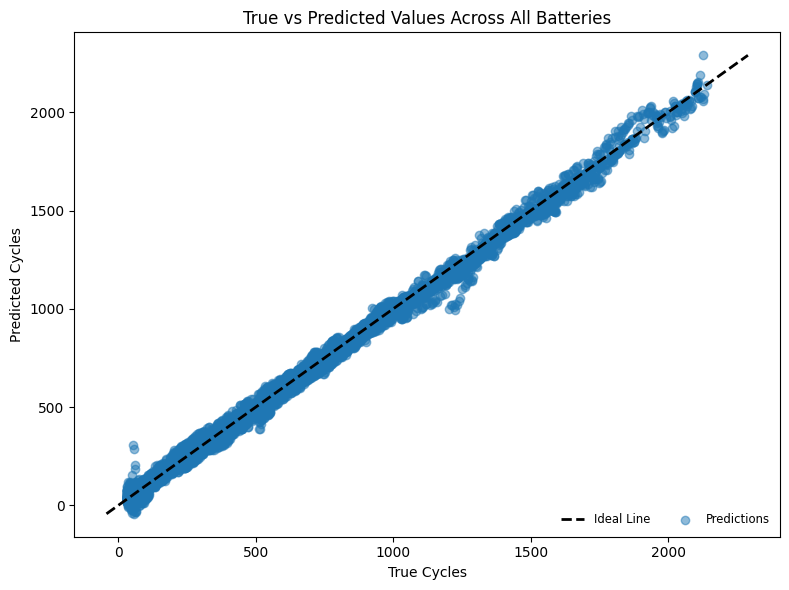

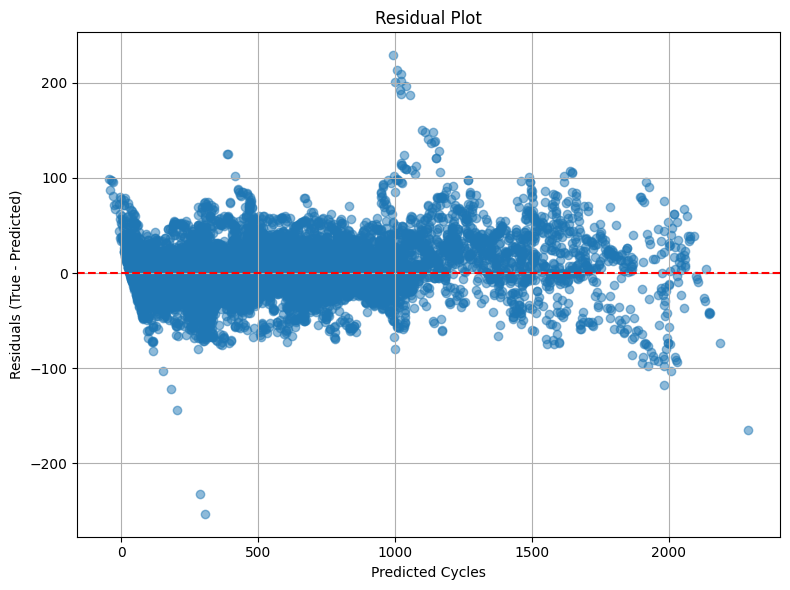

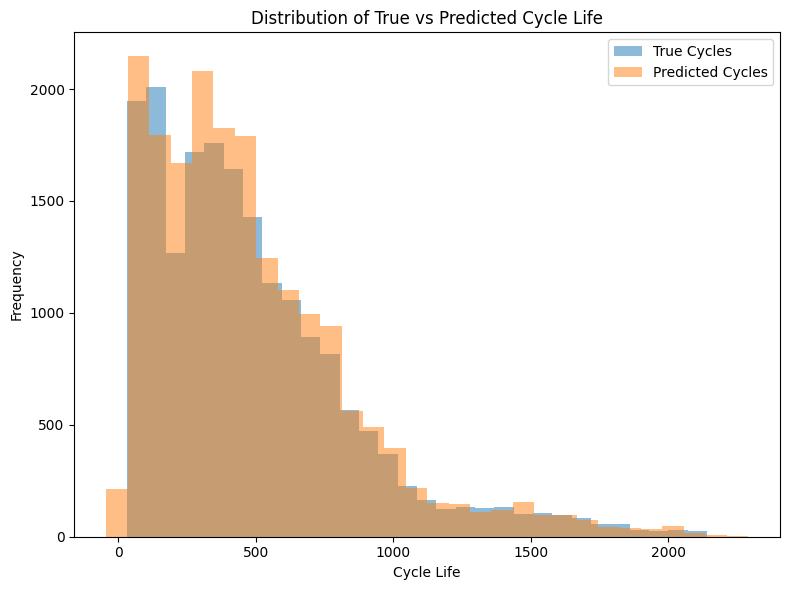

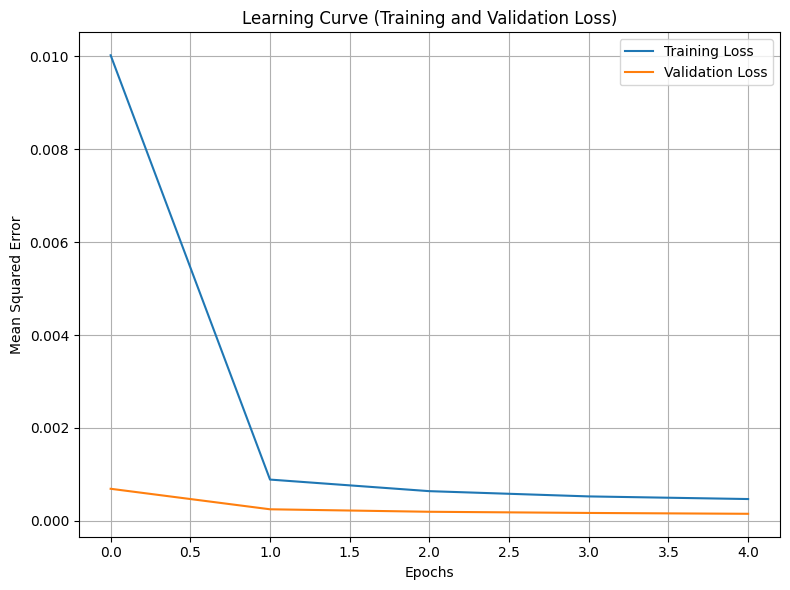

In [43]:
# Assuming `bat_dict` is already created by merging batch1, batch2, and batch3
# and contains cleaned data for each battery in `cleaned_summary`.

# Step 1: Extract, stack, and scale features and targets per battery
features_list = []
target_list = []

for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    # Stack features and extract target for each batch
    features = np.column_stack((summary['IR'], summary['QC'], summary['Tavg'], summary['Tmin'],
                                summary['Tmax'], summary['chargetime'], summary['QD']))
    target = summary['cycle']  # Assuming cycle is the target

    features_list.append(features)
    target_list.append(target)

# Concatenate all features and targets
features = np.vstack(features_list)
target = np.hstack(target_list)

# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Separate scaled data for each battery
features_scaled_by_battery = []
target_scaled_by_battery = []
index = 0

for batch in features_list:
    n_rows = batch.shape[0]
    features_scaled_by_battery.append(features_scaled[index:index + n_rows])
    target_scaled_by_battery.append(target_scaled[index:index + n_rows].flatten())
    index += n_rows

# Step 2: Define sliding window function for creating sequences
timesteps = 30

def create_sequences(features, target, timesteps):
    X, y = [], []
    for i in range(len(features) - timesteps):
        X.append(features[i:i + timesteps])  # Sequence of 30 cycles
        y.append(target[i + timesteps])      # Target is the next cycle's value
    return np.array(X), np.array(y)

# Step 3: Build the LSTM model with group-based training per battery
batch_size = 32
epochs_per_battery = 5

model = Sequential([
    LSTM(64, input_shape=(timesteps, features_scaled_by_battery[0].shape[1]), activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Lists for storing overall results
all_y_test, all_y_pred = [], []

# Train and evaluate the model per battery
for features_battery, target_battery in zip(features_scaled_by_battery, target_scaled_by_battery):
    # Create sequences for the current battery
    X_battery, y_battery = create_sequences(features_battery, target_battery, timesteps)

    # Ensure sequence length is compatible with batch size
    if X_battery.shape[0] % batch_size != 0:
        trim_size = X_battery.shape[0] % batch_size
        X_battery = X_battery[:-trim_size]
        y_battery = y_battery[:-trim_size]

    # Split battery data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_battery, y_battery, test_size=0.2, random_state=42)

    # Train the model on the current battery data
    history = model.fit(X_train, y_train, epochs=epochs_per_battery, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    
    # Evaluate and make predictions on the test set for the current battery
    y_pred = model.predict(X_test, batch_size=batch_size)
    
    # Store results for this battery
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred.flatten())

# Step 4: Rescale predictions and actual values
all_y_test = scaler_target.inverse_transform(np.array(all_y_test).reshape(-1, 1)).flatten()
all_y_pred = scaler_target.inverse_transform(np.array(all_y_pred).reshape(-1, 1)).flatten()

# Plot 1: True vs Predicted Scatter Plot with Ideal Line
plt.figure(figsize=(8, 6))
min_val, max_val = min(all_y_test.min(), all_y_pred.min()), max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Line')
plt.scatter(all_y_test, all_y_pred, alpha=0.5, label='Predictions')
plt.xlabel('True Cycles')
plt.ylabel('Predicted Cycles')
plt.title('True vs Predicted Values Across All Batteries')
plt.legend(fontsize='smaller', loc='lower right', ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot
residuals = all_y_test - all_y_pred
plt.figure(figsize=(8, 6))
plt.scatter(all_y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Cycles')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Distribution of True vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.hist(all_y_test, bins=30, alpha=0.5, label='True Cycles')
plt.hist(all_y_pred, bins=30, alpha=0.5, label='Predicted Cycles')
plt.xlabel('Cycle Life')
plt.ylabel('Frequency')
plt.title('Distribution of True vs Predicted Cycle Life')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve (Training and Validation Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. 10% cycle to end of cycle ###


In [44]:
# Set the percentage of initial cycles to use as input
percentage = 5  # Set to any desired percentage

# Initialize `C_hat` list by extracting `cycle_life` for each battery in `bat_dict`
C_hat = []
for battery_id, battery_data in bat_dict.items():
    cycle_life = battery_data['cycle_life']  # Access cycle_life for each battery
    C_hat.append(float(cycle_life[0][0]) if isinstance(cycle_life, np.ndarray) else float(cycle_life))

# Step 1: Extract the first `percentage` of cycles for each battery and set `C_hat` as the target
features_list = []
target_list = C_hat  # Use extracted `C_hat` as the target

# Find the maximum number of cycles needed to avoid shape mismatches
max_cycles = 0

for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use
    max_cycles = max(max_cycles, n_initial_cycles)  # Track the maximum cycles for padding

# Now, extract features and apply padding to match `max_cycles`
for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use

    # Use the first `n_initial_cycles` cycles as features and pad to `max_cycles`
    features = np.column_stack((summary['IR'][:n_initial_cycles], summary['QC'][:n_initial_cycles],
                                summary['Tavg'][:n_initial_cycles], summary['Tmin'][:n_initial_cycles],
                                summary['Tmax'][:n_initial_cycles], summary['chargetime'][:n_initial_cycles],
                                summary['QD'][:n_initial_cycles]))
    
    # Pad with zeros if the sequence is shorter than `max_cycles`
    if n_initial_cycles < max_cycles:
        padding = np.zeros((max_cycles - n_initial_cycles, features.shape[1]))
        features = np.vstack((features, padding))
    
    features_list.append(features)

# Stack features for scaling and prepare the target
features = np.stack(features_list)  # Shape: (num_batteries, max_cycles, num_features)
target = np.array(target_list)      # Shape: (num_batteries,)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Reshape features for scaling (flatten to 2D, then reshape back after scaling)
num_batteries, max_cycles, num_features = features.shape
features_scaled = scaler_features.fit_transform(features.reshape(-1, num_features)).reshape(num_batteries, max_cycles, num_features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Step 3: Build an LSTM model to predict EOL (C_hat)
timesteps = max_cycles  # Number of cycles in each sequence based on `percentage`
batch_size = 1          # Use batch size of 1 due to limited data
epochs = 100            # More epochs due to limited data

model = Sequential([
    LSTM(32, input_shape=(timesteps, num_features), activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression (predicting a single C_hat value)
])

# Compile the model

model.compile(optimizer=Adam(), loss=Huber(delta=1.0), metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Step 4: Make predictions and rescale to interpret actual values
y_pred_scaled = model.predict(X_test, batch_size=batch_size)
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()

# Displaying the first few predictions
for i in range(len(y_pred)):
    print(f'Predicted EOL (C_hat): {y_pred[i]:.2f}, Actual EOL (C_hat): {y_test[i]:.2f}')

# Plot 1: True vs Predicted EOL (C_hat) Scatter Plot with Ideal Line
plt.figure(figsize=(8, 6))
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Line')
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.xlabel('True EOL (C_hat)')
plt.ylabel('Predicted EOL (C_hat)')
plt.title('True vs Predicted End-of-Life (EOL) Cycles (C_hat)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted EOL (C_hat)')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot for EOL Prediction (C_hat)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve (Training and Validation Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Define a threshold (e.g., ±10 cycles) to measure "accuracy-like" performance

within_threshold = np.abs(y_test - y_pred) <= percentage
accuracy_like = np.mean(within_threshold) * 100  # Percentage of predictions within threshold

# Print out performance metrics
print("\nPerformance Indicators:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Accuracy-like metric (within ±{percentage} cycles): {accuracy_like:.2f}%")


Epoch 1/100


C:\Users\marif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0253 - mae: 0.1591 - val_loss: 0.0216 - val_mae: 0.1584
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0169 - mae: 0.1367 - val_loss: 0.0214 - val_mae: 0.1581
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0125 - mae: 0.1199 - val_loss: 0.0210 - val_mae: 0.1573
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0158 - mae: 0.1375 - val_loss: 0.0215 - val_mae: 0.1577
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162 - mae: 0.1375 - val_loss: 0.0227 - val_mae: 0.1586
Epoch 6/100
 49/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0908

KeyboardInterrupt: 

C:\Users\marif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 256ms/step - loss: 0.0406 - mae: 0.2162 - val_loss: 0.0211 - val_mae: 0.1579
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.0261 - mae: 0.1751 - val_loss: 0.0214 - val_mae: 0.1575
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0182 - mae: 0.1508 - val_loss: 0.0058 - val_mae: 0.0848
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0125 - mae: 0.1298 - val_loss: 0.0098 - val_mae: 0.1215
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0119 - mae: 0.1160 - val_loss: 0.0207 - val_mae: 0.1549
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0120 - mae: 0.1196 - val_loss: 0.0057 - val_mae: 0.0918
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0079 - mae: 0.1026 - val_loss: 0.0071 - val_mae: 0.1026
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0091 - mae: 0.1101 - val_loss: 0.0195 - val_mae: 0.1527
Epoch 9/100
100/100 ━━━━━━

C:\Users\marif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


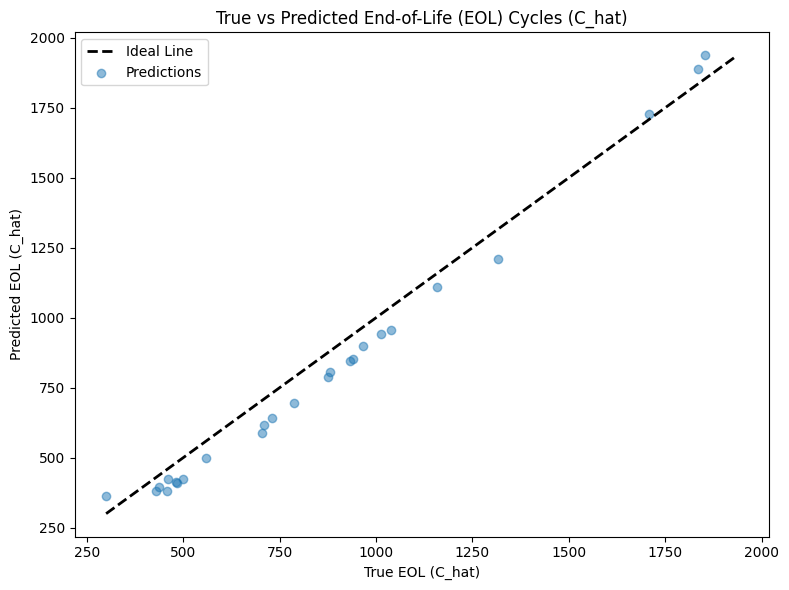

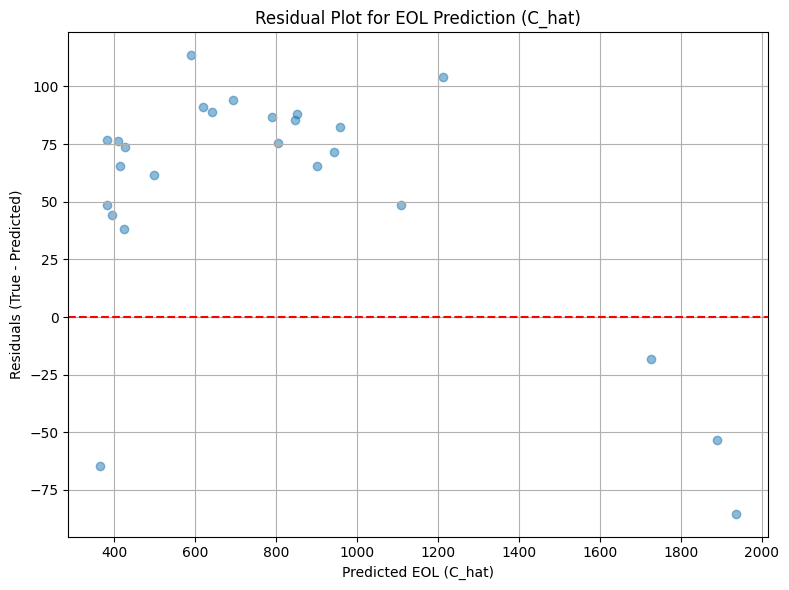

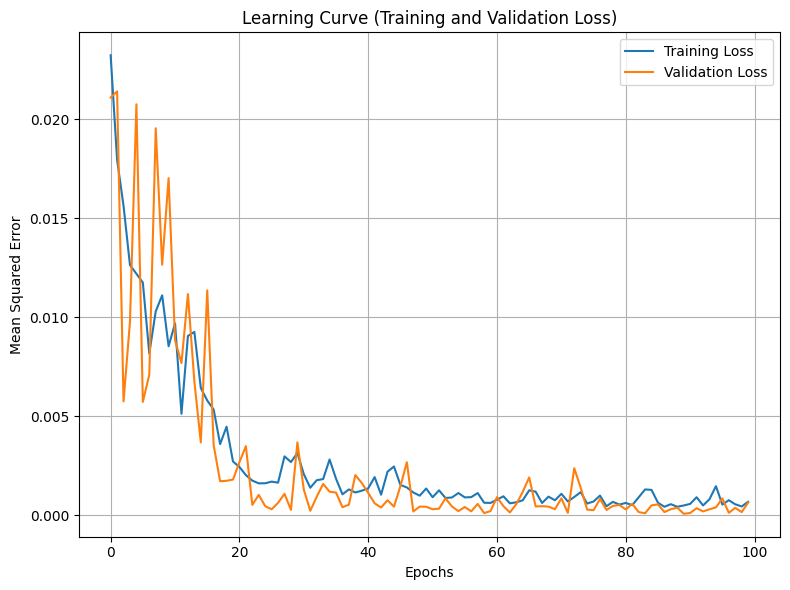


Performance Indicators:
Mean Absolute Error (MAE): 72.08
Mean Squared Error (MSE): 5651.36
Root Mean Squared Error (RMSE): 75.18
R-squared (R2): 0.97
Accuracy-like metric (within ±7 cycles): 0.00%


In [ ]:
# Set the percentage of initial cycles to use as input
percentage = 7  # Set to any desired percentage

# Initialize `C_hat` list by extracting `cycle_life` for each battery in `bat_dict`
C_hat = []
for battery_id, battery_data in bat_dict.items():
    cycle_life = battery_data['cycle_life']  # Access cycle_life for each battery
    C_hat.append(float(cycle_life[0][0]) if isinstance(cycle_life, np.ndarray) else float(cycle_life))

# Step 1: Extract the first `percentage` of cycles for each battery and set `C_hat` as the target
features_list = []
target_list = C_hat  # Use extracted `C_hat` as the target

# Find the maximum number of cycles needed to avoid shape mismatches
max_cycles = 0

for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use
    max_cycles = max(max_cycles, n_initial_cycles)  # Track the maximum cycles for padding

# Now, extract features and apply padding to match `max_cycles`
for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use

    # Use the first `n_initial_cycles` cycles as features and pad to `max_cycles`
    features = np.column_stack((summary['IR'][:n_initial_cycles], summary['QC'][:n_initial_cycles],
                                summary['Tavg'][:n_initial_cycles], summary['Tmin'][:n_initial_cycles],
                                summary['Tmax'][:n_initial_cycles], summary['chargetime'][:n_initial_cycles],
                                summary['QD'][:n_initial_cycles]))
    
    # Pad with zeros if the sequence is shorter than `max_cycles`
    if n_initial_cycles < max_cycles:
        padding = np.zeros((max_cycles - n_initial_cycles, features.shape[1]))
        features = np.vstack((features, padding))
    
    features_list.append(features)

# Stack features for scaling and prepare the target
features = np.stack(features_list)  # Shape: (num_batteries, max_cycles, num_features)
target = np.array(target_list)      # Shape: (num_batteries,)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Reshape features for scaling (flatten to 2D, then reshape back after scaling)
num_batteries, max_cycles, num_features = features.shape
features_scaled = scaler_features.fit_transform(features.reshape(-1, num_features)).reshape(num_batteries, max_cycles, num_features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Step 3: Build an LSTM model to predict EOL (C_hat)
timesteps = max_cycles  # Number of cycles in each sequence based on `percentage`
batch_size = 1          # Use batch size of 1 due to limited data
epochs = 100            # More epochs due to limited data

model = Sequential([
    LSTM(32, input_shape=(timesteps, num_features), activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression (predicting a single C_hat value)
])

# Compile the model

model.compile(optimizer=Adam(), loss=Huber(delta=1.0), metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Step 4: Make predictions and rescale to interpret actual values
y_pred_scaled = model.predict(X_test, batch_size=batch_size)
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()

# Displaying the first few predictions
for i in range(len(y_pred)):
    print(f'Predicted EOL (C_hat): {y_pred[i]:.2f}, Actual EOL (C_hat): {y_test[i]:.2f}')

# Plot 1: True vs Predicted EOL (C_hat) Scatter Plot with Ideal Line
plt.figure(figsize=(8, 6))
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Line')
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.xlabel('True EOL (C_hat)')
plt.ylabel('Predicted EOL (C_hat)')
plt.title('True vs Predicted End-of-Life (EOL) Cycles (C_hat)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted EOL (C_hat)')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot for EOL Prediction (C_hat)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve (Training and Validation Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Define a threshold (e.g., ±10 cycles) to measure "accuracy-like" performance

within_threshold = np.abs(y_test - y_pred) <= percentage
accuracy_like = np.mean(within_threshold) * 100  # Percentage of predictions within threshold

# Print out performance metrics
print("\nPerformance Indicators:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Accuracy-like metric (within ±{percentage} cycles): {accuracy_like:.2f}%")


C:\Users\marif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - loss: 0.0190 - mae: 0.1316 - val_loss: 0.0223 - val_mae: 0.1588
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0163 - mae: 0.1390 - val_loss: 0.0223 - val_mae: 0.1586
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0152 - mae: 0.1362 - val_loss: 0.0201 - val_mae: 0.1543
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 0.0198 - mae: 0.1444 - val_loss: 0.0216 - val_mae: 0.1584
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0157 - mae: 0.1365 - val_loss: 0.0217 - val_mae: 0.1583
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.0157 - mae: 0.1378 - val_loss: 0.0225 - val_mae: 0.1590
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0168 - mae: 0.1339 - val_loss: 0.0215 - val_mae: 0.1585
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0097 - mae: 0.1113 - val_loss: 0.0217 - val_mae: 0.1582
Epoch 9/100
100/100 ━━━━━━━━━━

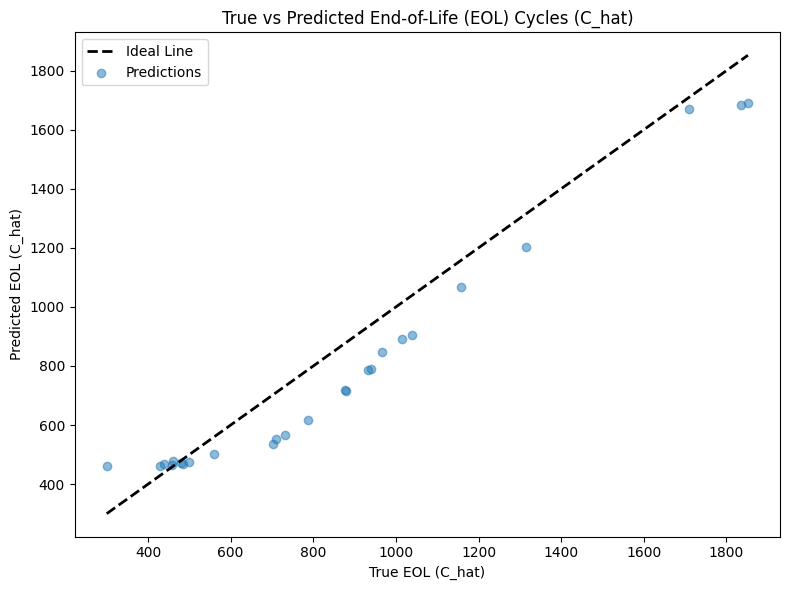

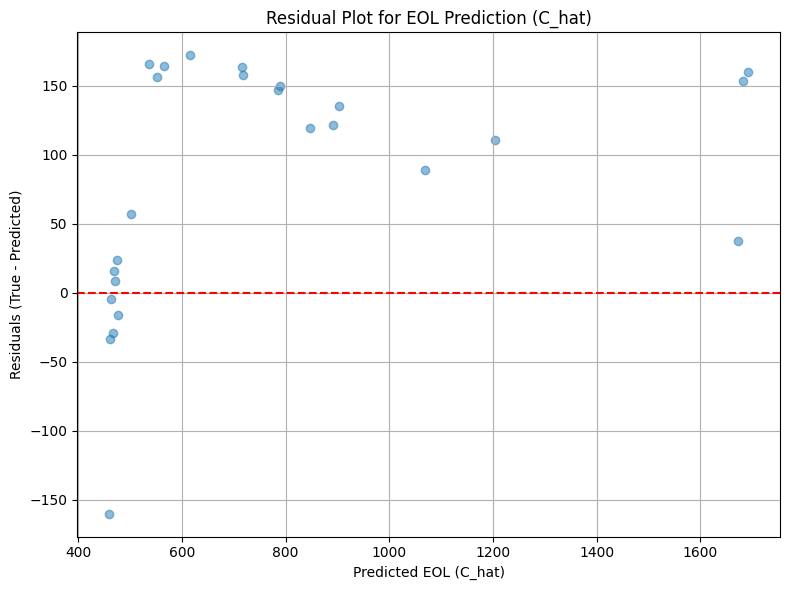

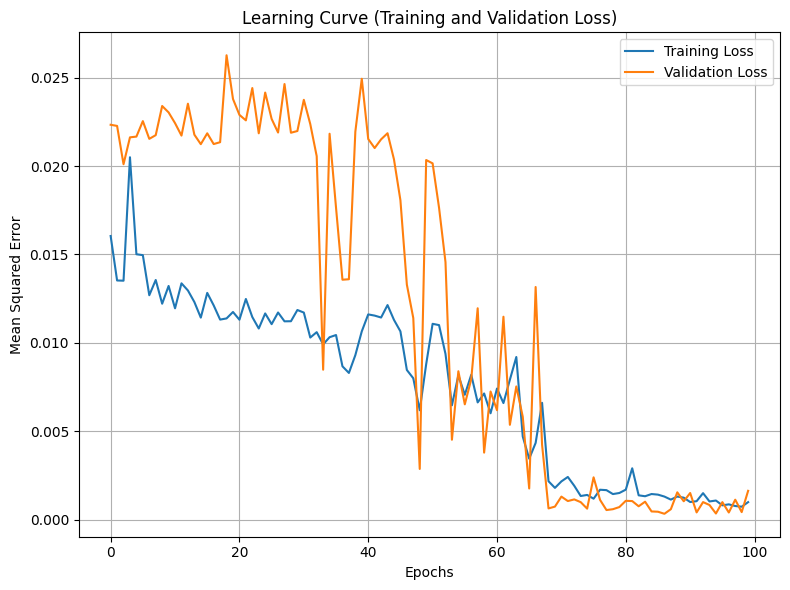


Performance Indicators:
Mean Absolute Error (MAE): 102.17
Mean Squared Error (MSE): 14204.83
Root Mean Squared Error (RMSE): 119.18
R-squared (R2): 0.92
Accuracy-like metric (within ±10 cycles): 8.00%


In [ ]:
# Set the percentage of initial cycles to use as input
percentage = 10  # Set to any desired percentage

# Initialize `C_hat` list by extracting `cycle_life` for each battery in `bat_dict`
C_hat = []
for battery_id, battery_data in bat_dict.items():
    cycle_life = battery_data['cycle_life']  # Access cycle_life for each battery
    C_hat.append(float(cycle_life[0][0]) if isinstance(cycle_life, np.ndarray) else float(cycle_life))

# Step 1: Extract the first `percentage` of cycles for each battery and set `C_hat` as the target
features_list = []
target_list = C_hat  # Use extracted `C_hat` as the target

# Find the maximum number of cycles needed to avoid shape mismatches
max_cycles = 0

for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use
    max_cycles = max(max_cycles, n_initial_cycles)  # Track the maximum cycles for padding

# Now, extract features and apply padding to match `max_cycles`
for batch in bat_dict.values():
    summary = batch['cleaned_summary']
    n_cycles = len(summary)
    n_initial_cycles = max(1, int((percentage / 100) * n_cycles))  # Calculate the number of cycles to use

    # Use the first `n_initial_cycles` cycles as features and pad to `max_cycles`
    features = np.column_stack((summary['IR'][:n_initial_cycles], summary['QC'][:n_initial_cycles],
                                summary['Tavg'][:n_initial_cycles], summary['Tmin'][:n_initial_cycles],
                                summary['Tmax'][:n_initial_cycles], summary['chargetime'][:n_initial_cycles],
                                summary['QD'][:n_initial_cycles]))
    
    # Pad with zeros if the sequence is shorter than `max_cycles`
    if n_initial_cycles < max_cycles:
        padding = np.zeros((max_cycles - n_initial_cycles, features.shape[1]))
        features = np.vstack((features, padding))
    
    features_list.append(features)

# Stack features for scaling and prepare the target
features = np.stack(features_list)  # Shape: (num_batteries, max_cycles, num_features)
target = np.array(target_list)      # Shape: (num_batteries,)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Reshape features for scaling (flatten to 2D, then reshape back after scaling)
num_batteries, max_cycles, num_features = features.shape
features_scaled = scaler_features.fit_transform(features.reshape(-1, num_features)).reshape(num_batteries, max_cycles, num_features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Step 3: Build an LSTM model to predict EOL (C_hat)
timesteps = max_cycles  # Number of cycles in each sequence based on `percentage`
batch_size = 1          # Use batch size of 1 due to limited data
epochs = 100            # More epochs due to limited data

model = Sequential([
    LSTM(64, input_shape=(timesteps, num_features), activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model

model.compile(optimizer=Adam(), loss=Huber(delta=1.0), metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Step 4: Make predictions and rescale to interpret actual values
y_pred_scaled = model.predict(X_test, batch_size=batch_size)
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()

# Displaying the first few predictions
for i in range(len(y_pred)):
    print(f'Predicted EOL (C_hat): {y_pred[i]:.2f}, Actual EOL (C_hat): {y_test[i]:.2f}')

# Plot 1: True vs Predicted EOL (C_hat) Scatter Plot with Ideal Line
plt.figure(figsize=(8, 6))
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Line')
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.xlabel('True EOL (C_hat)')
plt.ylabel('Predicted EOL (C_hat)')
plt.title('True vs Predicted End-of-Life (EOL) Cycles (C_hat)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted EOL (C_hat)')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot for EOL Prediction (C_hat)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve (Training and Validation Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Define a threshold (e.g., ±10 cycles) to measure "accuracy-like" performance

within_threshold = np.abs(y_test - y_pred) <= percentage
accuracy_like = np.mean(within_threshold) * 100  # Percentage of predictions within threshold

# Print out performance metrics
print("\nPerformance Indicators:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Accuracy-like metric (within ±{percentage} cycles): {accuracy_like:.2f}%")


### 3. Deep Cycle Analysis


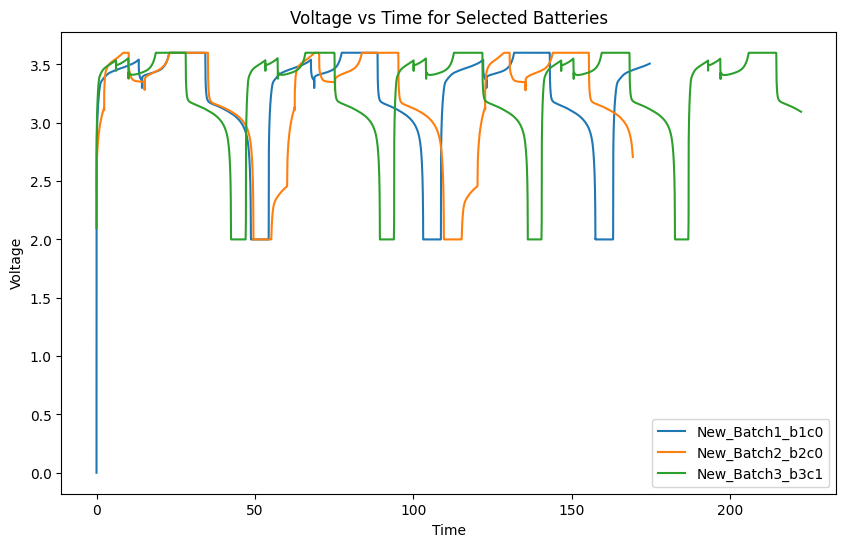

In [ ]:
def process_battery_batch(batch, batch_name):
    """
    Process battery data from a given batch.
    
    Parameters:
    - batch: Dictionary containing battery data.
    - batch_name: String identifier for the batch (e.g., 'batch1').

    Returns:
    - processed_batch: Dictionary containing processed data arrays for each battery in the batch.
    """
    processed_batch = {}

    for battery_id in batch.keys():
        # Create a new variable name for storage
        new_var_name = f"{batch_name}_{battery_id}"

        # Calculate the total number of time points across all cycles for the battery
        total_time_points = sum(len(batch[battery_id]['cycles'][str(i)]['t']) for i in batch[battery_id]['cycles'].keys())

        # Initialize an array with the total time points and six columns for t, I, Qc, Qd, T, V
        n_columns = 6
        battery_data = np.zeros((total_time_points, n_columns))

        # Insert cycle data into the battery_data array
        start_idx = 0
        for i in batch[battery_id]['cycles'].keys():
            cycle_data = batch[battery_id]['cycles'][i]
            cycle_length = len(cycle_data['t'])

            # Populate each parameter into the battery_data array
            if start_idx == 0:
                battery_data[start_idx:start_idx + cycle_length, 0] = cycle_data['t']
            else:
                # Accumulate time for continuous time across cycles
                battery_data[start_idx:start_idx + cycle_length, 0] = cycle_data['t'] + battery_data[start_idx - 1, 0]
            battery_data[start_idx:start_idx + cycle_length, 1] = cycle_data['I']  # Current
            battery_data[start_idx:start_idx + cycle_length, 2] = cycle_data['Qc']  # Charge capacity
            battery_data[start_idx:start_idx + cycle_length, 3] = cycle_data['Qd']  # Discharge capacity
            battery_data[start_idx:start_idx + cycle_length, 4] = cycle_data['T']  # Temperature
            battery_data[start_idx:start_idx + cycle_length, 5] = cycle_data['V']  # Voltage

            start_idx += cycle_length  # Move the index forward for the next cycle

        # Store the processed data in the dictionary
        processed_batch[new_var_name] = battery_data

    return processed_batch

# Process each batch using the function
New_Batch1 = process_battery_batch(batch1, "New_Batch1")
New_Batch2 = process_battery_batch(batch2, "New_Batch2")
New_Batch3 = process_battery_batch(batch3, "New_Batch3")


In [ ]:
# Extract data from all batteries in New_Batch1, New_Batch2, and New_Batch3
batches = list(New_Batch1.values()) + list(New_Batch2.values()) + list(New_Batch3.values())

# Extracting features and targets from all batches
features_list = []
target_list = []

for batch in batches:
    features_list.append(batch[:, :5])  # Use columns: t, I, Qc, T, V as features
    target_list.append(batch[:, 3])    # Use Qd (Discharge capacity) as target

# Concatenate all features and targets
features = np.vstack(features_list)  # Shape: (total_samples, 5)
target = np.hstack(target_list)      # Shape: (total_samples,)

# Scale the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

# Reshape features for LSTM (samples, timesteps, features)
# Here we consider a sequence of 5 time points as a timestep
timesteps = 5
features_scaled = features_scaled[:features_scaled.shape[0] // timesteps * timesteps]
features_scaled = features_scaled.reshape((-1, timesteps, features.shape[1]))
target_scaled = target_scaled[:target_scaled.shape[0] // timesteps * timesteps]
target_scaled = target_scaled.reshape((-1, timesteps))[:, -1]  # Take the last timestep in each sequence as the target

# Implementing TimeSeriesSplit Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)
fold = 1
all_mse = []
all_f1_scores = []

for train_index, test_index in tscv.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target_scaled[train_index], target_scaled[test_index]

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse'])

    # Add early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Evaluate the model
    loss, mse = model.evaluate(X_test, y_test, verbose=0)
    all_mse.append(mse)
    print(f'Fold {fold} - Test Loss: {loss}, Test MSE: {mse}')

    # Making predictions
    y_pred_scaled = model.predict(X_test)

    # Inverse transform the predictions and true values for interpretability
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Calculate F1 score (binary/multiclass classification needs thresholding for regression)
    threshold = 1.0  # Set based on data characteristics
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test_original >= threshold).astype(int)
    f1 = f1_score(y_test_binary, y_pred_binary, average='binary')
    all_f1_scores.append(f1)
    print(f'Fold {fold} - F1 Score: {f1}')
    fold += 1

# Calculate average MSE and F1 Score across all folds
average_mse = np.mean(all_mse)
average_f1 = np.mean(all_f1_scores)
print(f'Average MSE across all folds: {average_mse}')
print(f'Average F1 Score across all folds: {average_f1}')

# Plotting the training and validation MSE for the last fold
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE over Epochs')
plt.show()

# Plotting Actual vs Predicted values for the last fold
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('QD Value')
plt.legend()
plt.title('Actual vs Predicted QD Values')
plt.show()

# Displaying the first few predictions
for i in range(min(50, len(y_pred))):
    print(f'Predicted: {y_pred[i][0]:.2f}, Actual: {y_test_original[i][0]:.2f}')

# Archives